# UNet Model with VGG19 with Imagenet weights as backbone

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Image Segmentation Library

In [2]:
pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.1 MB/s 


## Importing Required dependenceis

In [3]:
import tensorflow as tf
from pathlib import Path
import albumentations as A
from random import choice
import numpy as np
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import os
import segmentation_models as SM
import numpy as np
from torchvision.transforms.functional import to_tensor,to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from segmentation_models.metrics import iou_score, f1_score
import keras
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from segmentation_models.losses import bce_jaccard_loss

Segmentation Models: using `keras` framework.


### Hyper Parameters and Configuration parameters

In [4]:
tf.random.set_seed(11)
LEARNING_RATE = 1e-4
DEVICE = 'GPU' if tf.config.list_physical_devices() else "CPU"
BATCH_SIZE = 4
NUM_EPOCHS = 20
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_IMG_DIR = Path('/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train')
TEST_IMG_DIR = Path('/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_test')
TRAIN_MASK_DIR = Path('/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train')
TEST_MASK_DIR = Path('/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_test')

## Reading Images from GDrive Paths

In [5]:
train_images = list((TRAIN_IMG_DIR).glob("*.png"))
train_masks = list((TRAIN_MASK_DIR ).glob("*.png"))
test_images = list((TEST_IMG_DIR).glob("*.png"))
test_masks = list((TEST_MASK_DIR ).glob("*.png"))

## Sorting Images so that the train-val split gets images and respective masks in order

In [6]:
train_images =  sorted(train_images) 
train_masks = sorted(train_masks ) 
test_images = sorted(test_images) 
test_masks = sorted(test_masks) 

## Train and Validation Split

In [7]:
train_img, val_img, train_mask, val_mask = train_test_split(train_images, train_masks, test_size=0.25, random_state=11)

In [8]:
len(train_img), len(val_img), len(train_mask), len(val_mask) 

(275, 92, 275, 92)

## Function to make pairs of Images and their Corresponding Masks

In [9]:
def image_mask_pairs(images, masks):
  pairs = []
  for pair in zip(images, masks):
    pairs.append(pair)
  return pairs

## Makig Image Mask Pairs

In [10]:
train_pairs = image_mask_pairs(train_img, train_mask)
val_pairs = image_mask_pairs(val_img, val_mask)
test_pairs = image_mask_pairs(test_images, test_masks)

## Data Augmentations
#### I have used Albumntations Library for data Augmentations. I provides useful augmentation features for segmentation data

In [11]:
train_transform = A.Compose(
        [
            A.Rotate(limit=35, p=0.4),
            A.OneOf([
            A.HorizontalFlip(p=1.0),
            A.VerticalFlip(p=1.0),
            ]),
            A.Blur (blur_limit=3, always_apply=False, p=0.2),
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
        ],
    )
val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
        ],
    )

## Making Dataset class, this class loads image batches and applies augmentation scripts written above
### This Dataset class is written with the help of following guide on Stanford University's website
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [12]:
class City_Scape_Dataset(Sequence):
  
  def __init__(self, pair, transform = None, batch_size=4, dim=(224,224,3), shuffle=True):
    self.dim = dim
    self.pair = pair
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.transform = transform
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.pair) / self.batch_size))

  def __getitem__(self, idx):
    indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
    list_IDs_temp = [k for k in indexes]
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.pair))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    batch_imgs = list()
    batch_labels = list()
    for i in list_IDs_temp:
      img = load_img(self.pair[i][0])
      label = load_img(self.pair[i][1], color_mode='grayscale')
      if self.transform is not None:
        transformed = self.transform(image=np.array(img), mask=np.array(label))
        img = transformed['image']
        label = transformed['mask']
      batch_imgs.append(img)
      label = to_categorical(label, num_classes=12)
      batch_labels.append(np.array(label))
        
    return np.array(batch_imgs) ,np.array(batch_labels)

### Loading Data

In [13]:
train_data = City_Scape_Dataset(train_pairs, train_transform, batch_size=BATCH_SIZE, dim=(IMAGE_WIDTH,IMAGE_HEIGHT,3), shuffle=True)
val_data = City_Scape_Dataset(val_pairs, train_transform, batch_size=BATCH_SIZE, dim=(IMAGE_WIDTH,IMAGE_HEIGHT,3), shuffle=True)
test_data = City_Scape_Dataset(test_pairs, val_transform, batch_size=BATCH_SIZE, dim=(IMAGE_WIDTH,IMAGE_HEIGHT,3), shuffle=True)

### Specifity and Sensitivity metrics definations, io_score, auccuracy and f1-score are imported from segmentation models library

In [14]:
def specifity(ground_truth_mask, pred_mask):
  neg_ground_truth_mask = 1 - ground_truth_mask
  neg_pred_mask = 1 - pred_mask
  false_positive = keras.backend.sum(neg_ground_truth_mask * pred_mask)
  true_negative = keras.backend.sum(neg_ground_truth_mask * neg_pred_mask)
  spec = true_negative / (true_negative + false_positive + keras.backend.epsilon())
  return spec

def sensitivity(ground_truth_mask, pred_mask):
  neg_pred_mask = 1 - pred_mask
  true_positive = keras.backend.sum(ground_truth_mask * pred_mask)
  false_negative = keras.backend.sum(neg_pred_mask * ground_truth_mask)
  sens = true_positive / (true_positive + false_negative + keras.backend.epsilon())
  return sens


### Function to Plot Data examples and overlay masks on images

In [15]:
def overlay_mask_on_image(img, mask, classes, colors):
  for ll in range(classes):
    boundries=(mask==ll)
    img=mark_boundaries(img, boundries, color=colors[ll], mode='thick')
  return img
def plot_examples(example, img_size):
  img = img_to_array(load_img(example[0], target_size=img_size))
  mask = img_to_array(load_img(example[1], target_size=img_size))
  boundry_colours = np.random.randint(0, 255, size=(12, 3),dtype="uint8")
  mask1 = Image.open(train_pairs[25][1])
  super_imposed_image = overlay_mask_on_image(img, mask[:, :, 0], 12, boundry_colours)
  plt.figure(figsize=(25,25))
  plt.subplot(1, 3, 1)
  plt.imshow(img/255)
  plt.title('Actual Image')
  plt.subplot(1, 3, 2)
  plt.imshow(mask1)
  plt.title('Ground Truth Mask')
  plt.subplot(1, 3, 3)
  plt.imshow(super_imposed_image/255)
  plt.title('Ground Truth Overlayed on Image')
  

### Plotting Examples

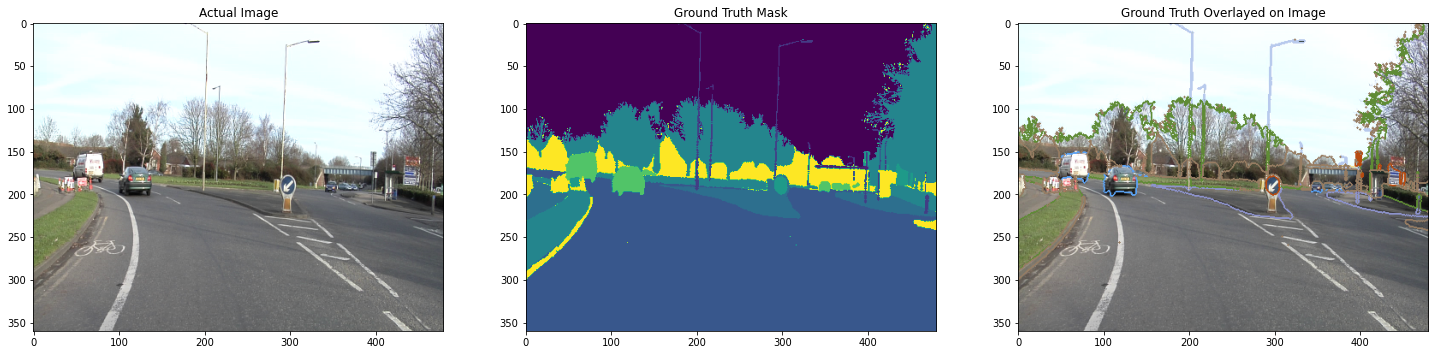

In [16]:
plot_examples(train_pairs[25], (360,480))


### Plotting Augmented Data Examples

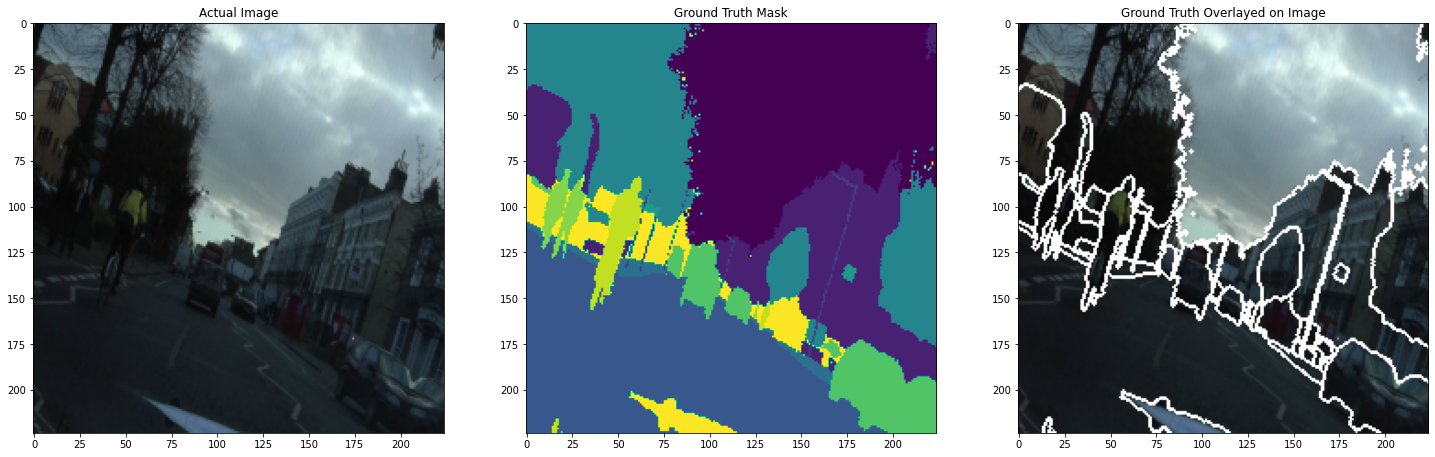

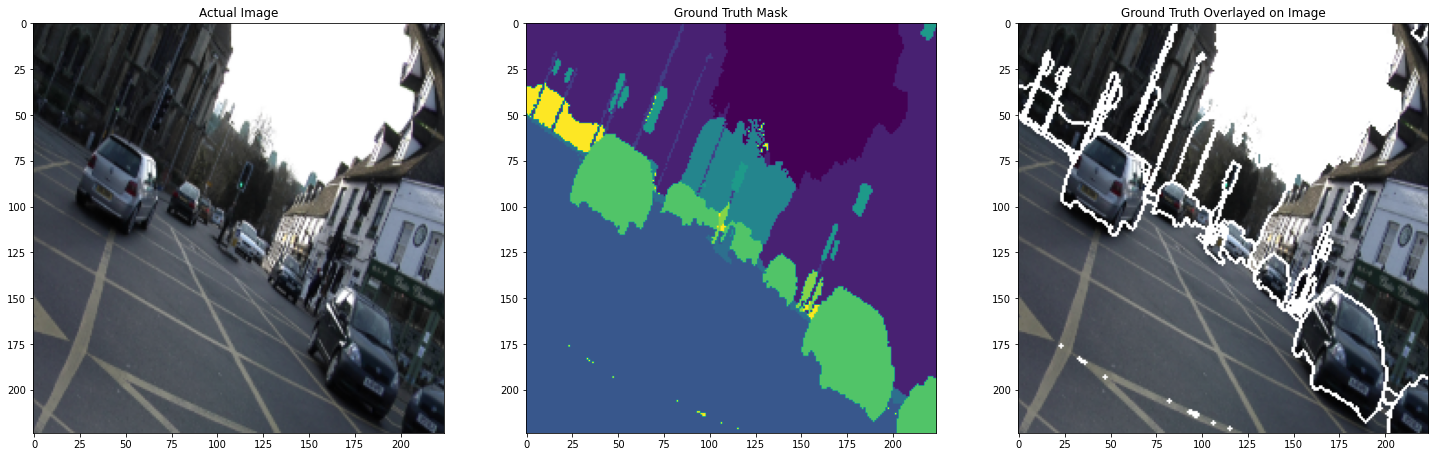

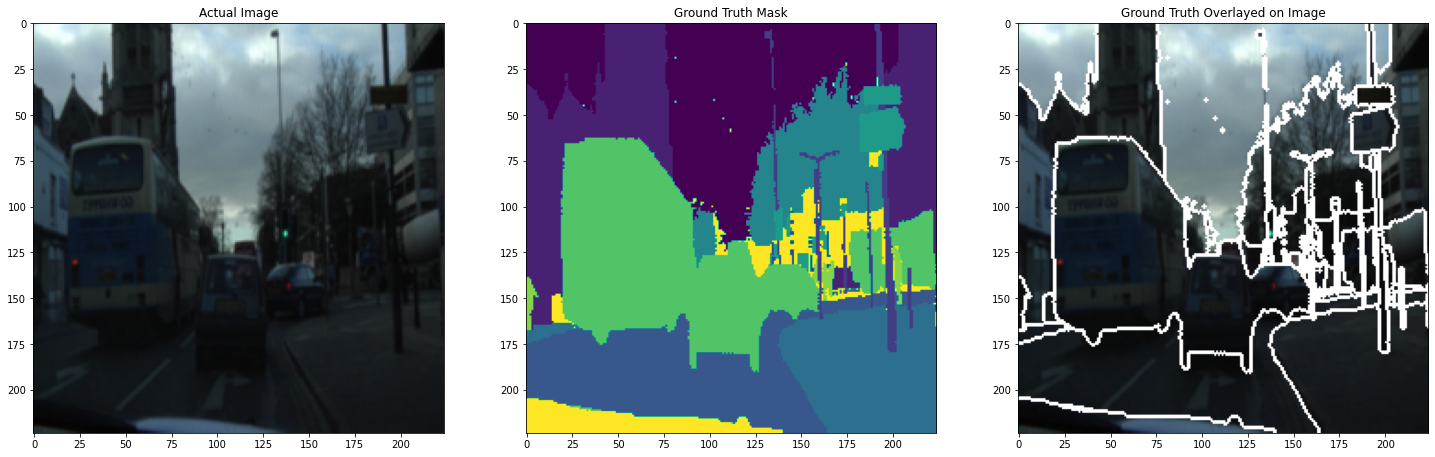

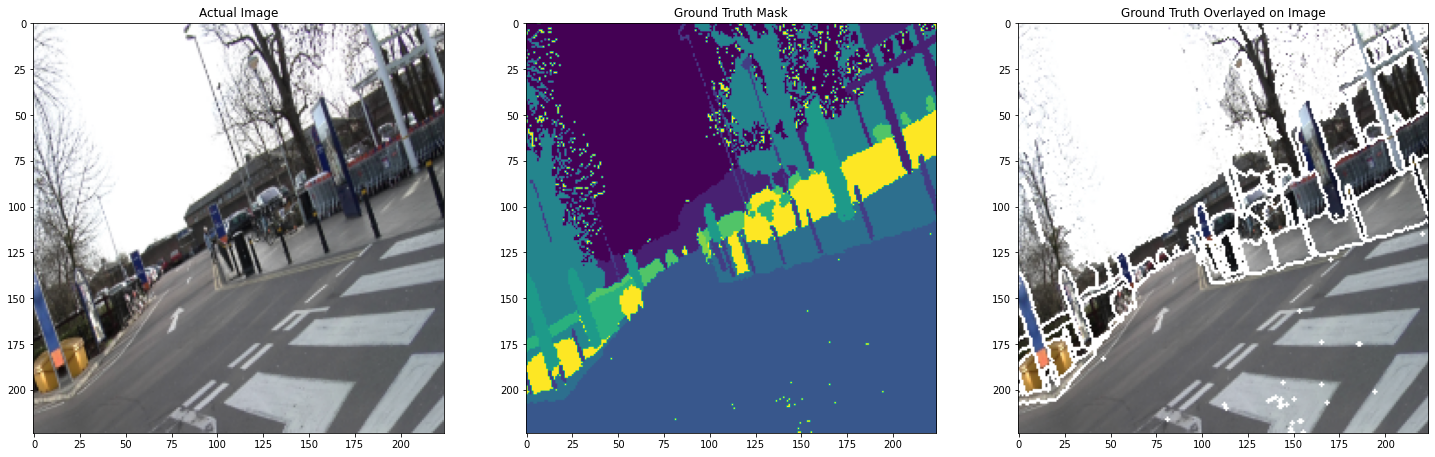

In [26]:
for batch in [1,5,15,20]: 
  img_batch, mask_batch = train_data[batch]
  img = img_batch[2]
  mask = mask_batch[2]
  mask = np.argmax(mask,axis=2)
  COLORS = np.random.randint(0, 128, size=(12+1,3),dtype="uint8")
  super_imposed_image = overlay_mask_on_image(img, mask[:,:], 12, COLORS)
  plt.figure(figsize=(25,25))
  plt.subplot(1, 3, 1)
  plt.imshow(img)
  plt.title('Actual Image')
  plt.subplot(1, 3, 2)
  plt.imshow(mask)
  plt.title('Ground Truth Mask')
  plt.subplot(1, 3, 3)
  plt.imshow(super_imposed_image)
  plt.title('Ground Truth Overlayed on Image')

# Loading Uner with VGG backbone, Imagenet weights

In [27]:
model1 = SM.Unet(backbone_name="vgg19", encoder_weights= 'imagenet', classes=12, encoder_freeze=True)

In [28]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

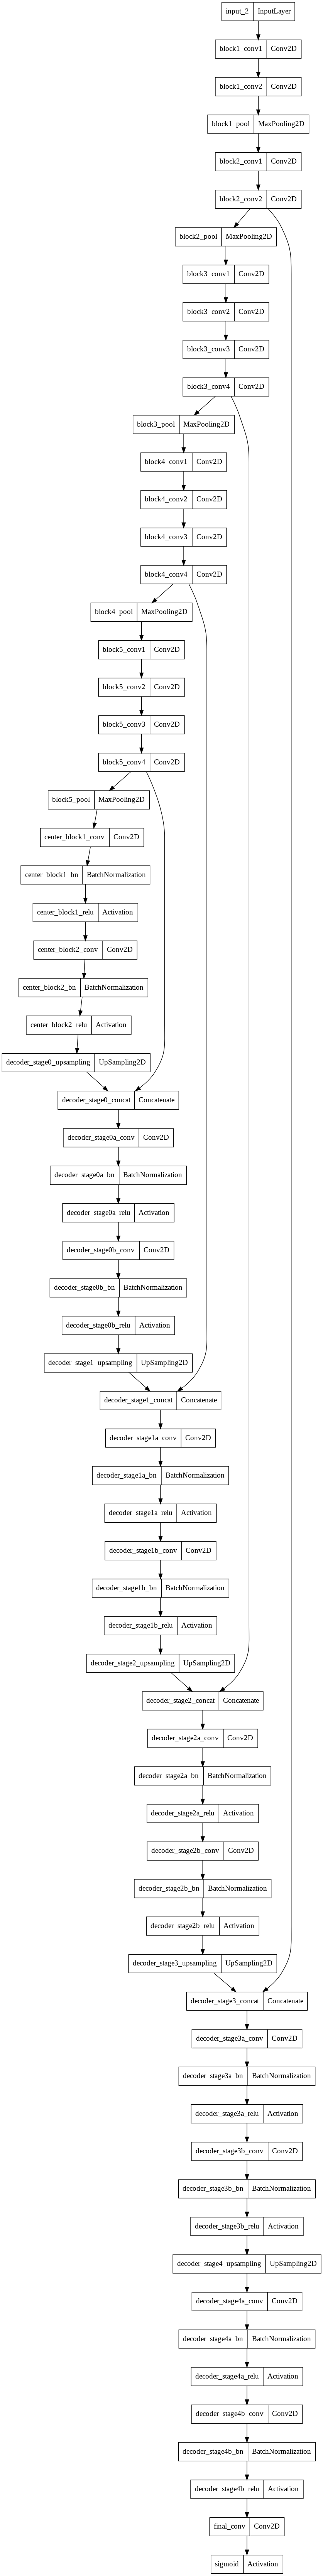

In [29]:
plot_model(model1)

### Compiling and Training Model

In [30]:
model1.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy',iou_score, specifity, sensitivity, f1_score])
model_name = "Unet with VGG backbone"

In [31]:
def train(model, train_data, val_data, epochs, model_name):  
  reduce_learning_rate = ReduceLROnPlateau(monitor='iou_score', factor=0.5, patience=2, 
                                    verbose=1, mode='max', min_lr=0.00001)
  saving_models = ModelCheckpoint('/content/drive/MyDrive/SavedModels/VGG/model' + str(model_name) +'.h5'
                                          ,verbose=1
                                          ,save_weights_only=True)
  results = model1.fit(train_data , steps_per_epoch=len(train_data) ,epochs=epochs,
                              validation_data=val_data, validation_steps=len(val_data), callbacks=[saving_models,reduce_learning_rate])
  return results

In [32]:

results1 = train(model=model1, train_data=train_data, val_data=val_data, epochs=25, model_name=model_name)

Epoch 1/25
68/68 [==============================] - ETA: 0s - loss: 1.3191 - accuracy: 0.6234 - iou_score: 0.1122 - specifity: 0.6151 - sensitivity: 0.7768 - f1-score: 0.1759
Epoch 1: saving model to /content/drive/MyDrive/SavedModels/VGG/modelUnet with VGG backbone.h5
68/68 [==============================] - 88s 1s/step - loss: 1.3191 - accuracy: 0.6234 - iou_score: 0.1122 - specifity: 0.6151 - sensitivity: 0.7768 - f1-score: 0.1759 - val_loss: 10.3883 - val_accuracy: 0.6154 - val_iou_score: 0.1406 - val_specifity: 0.7541 - val_sensitivity: 0.8236 - val_f1-score: 0.1998 - lr: 0.0010
Epoch 2/25
68/68 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.7645 - iou_score: 0.1489 - specifity: 0.7053 - sensitivity: 0.8782 - f1-score: 0.2191
Epoch 2: saving model to /content/drive/MyDrive/SavedModels/VGG/modelUnet with VGG backbone.h5
68/68 [==============================] - 9s 138ms/step - loss: 0.7908 - accuracy: 0.7645 - iou_score: 0.1489 - specifity: 0.7053 - sensitiv

### Function Defination to Plot Metics

In [33]:
def plots(metric, results, labels):
  plt.figure(figsize=(8, 8))
  plt.title(labels[0])
  plt.plot(results.history[metric[0]], label=labels[1])
  plt.plot(results.history[metric[1]], label="val_loss")
  plt.xlabel("Epochs")
  plt.ylabel(labels[1])
  plt.legend();
  plt.show()

## Loss Plot

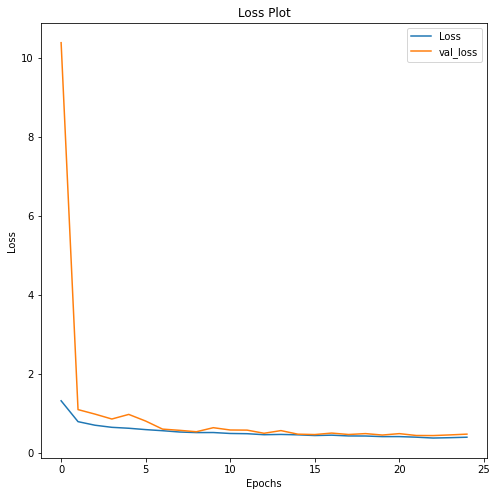

In [34]:
plots(["loss", "val_loss"], results1, ["Loss Plot", "Loss"])

## Accuracy Plot

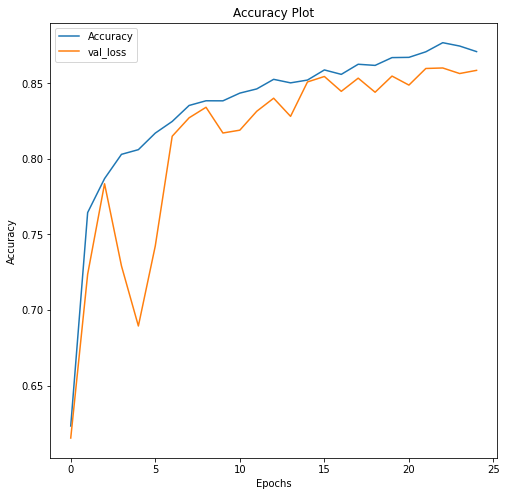

In [35]:
plots(["accuracy", "val_accuracy"], results1, ["Accuracy Plot", "Accuracy"])

## IOU Plot

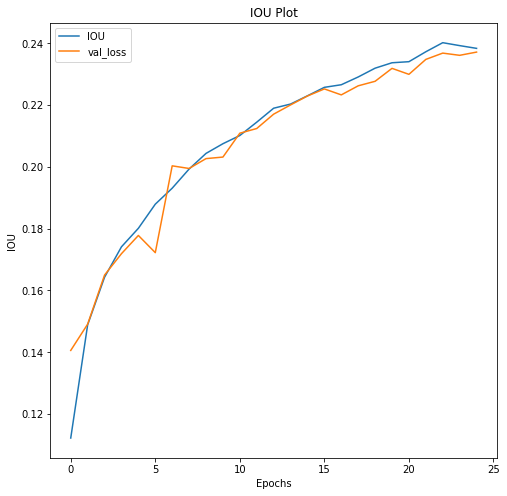

In [36]:
plots(["iou_score", "val_iou_score"], results1, ["IOU Plot", "IOU"])

## Sensitivity Plot

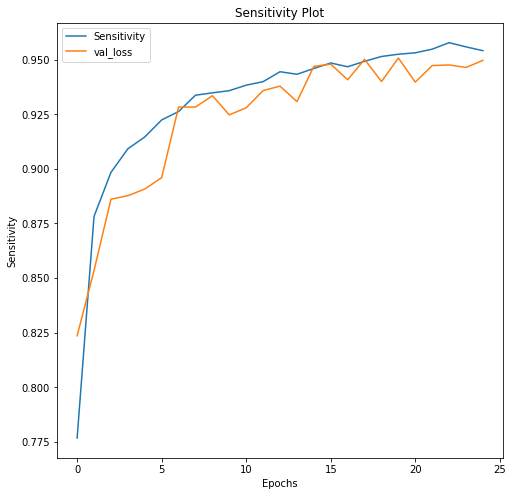

In [37]:
plots(["sensitivity", "val_sensitivity"], results1, ["Sensitivity Plot", "Sensitivity"])

## Specifity Plot

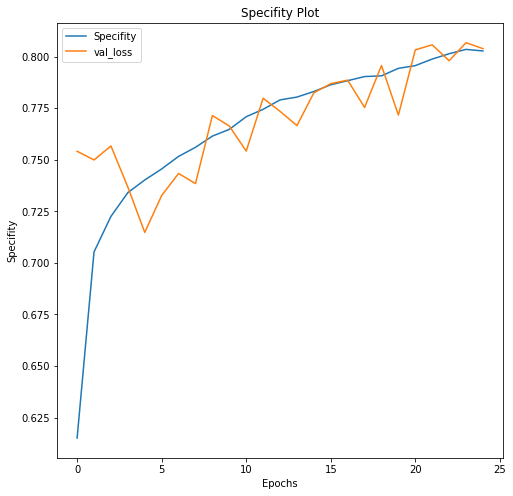

In [38]:
plots(["specifity", "val_specifity"], results1, ["Specifity Plot", "Specifity"])

## F1 Score Plot

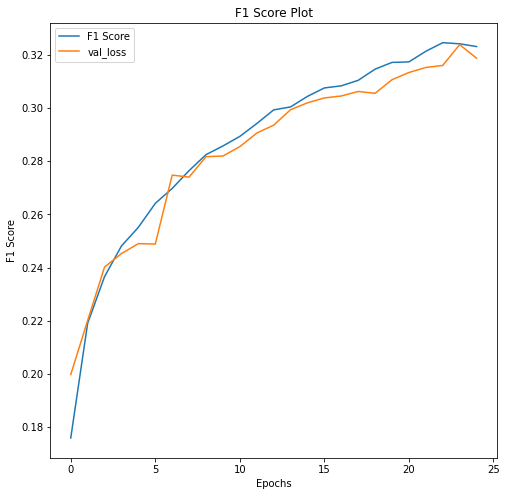

In [39]:
plots(["f1-score", "val_f1-score"], results1, ["F1 Score Plot", "F1 Score"])

## Evaluating Model on Test Data

In [40]:
model1.evaluate(test_data)

25/25 [==============================] - 48s 2s/step - loss: 0.4110 - accuracy: 0.8689 - iou_score: 0.2564 - specifity: 0.7889 - sensitivity: 0.9573 - f1-score: 0.3558


[0.41103360056877136,
 0.8688759803771973,
 0.2563968598842621,
 0.7888986468315125,
 0.957268476486206,
 0.3557527959346771]

### Function Defination to Plot Predicted mask and overlaying mask on the image

In [44]:
def plot_examples_after_training(example, idx, pred, img_size):
  img = img_to_array(load_img(example[idx][0], target_size=img_size))
  mask = img_to_array(load_img(example[idx][1], target_size=img_size))
  boundry_colours = np.random.randint(0, 255, size=(12, 3),dtype="uint8")
  mask1 = Image.open(example[idx][1])
  super_imposed_image = overlay_mask_on_image(img, mask[:, :, 0], 12, boundry_colours)
  plt.figure(figsize=(25,25))
  plt.subplot(1, 4, 1)
  plt.imshow(img/255)
  plt.title('Actual Image')
  plt.subplot(1, 4, 2)
  plt.imshow(mask1)
  plt.title('Ground Truth Mask')
  plt.subplot(1, 4, 3)
  plt.imshow(pred)
  plt.title('Predicted Mask')
  plt.subplot(1, 4, 4)
  plt.imshow(super_imposed_image/255)
  plt.title('Predicted Mask Overlayed on Image')

### Model Prediction

In [45]:
def model_prediction(model, image):
  prediction = model.predict(image)
  return np.argmax(prediction[0],axis=2)




### Plotting Qualitative Results

1/1 [==============================] - 0s 19ms/step


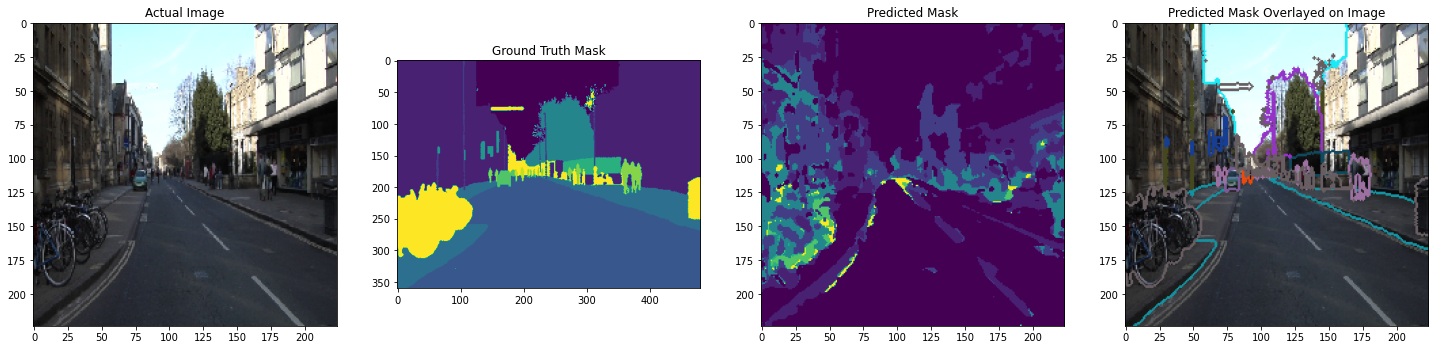

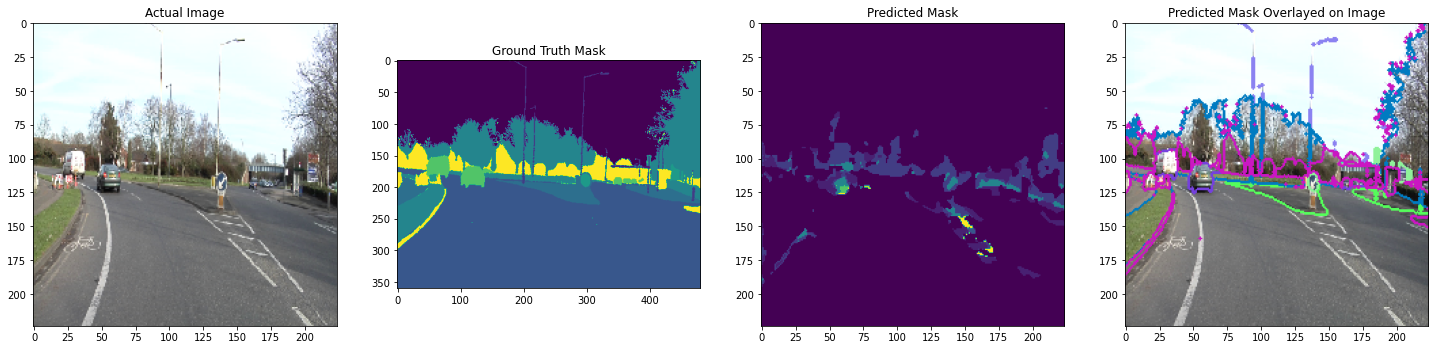

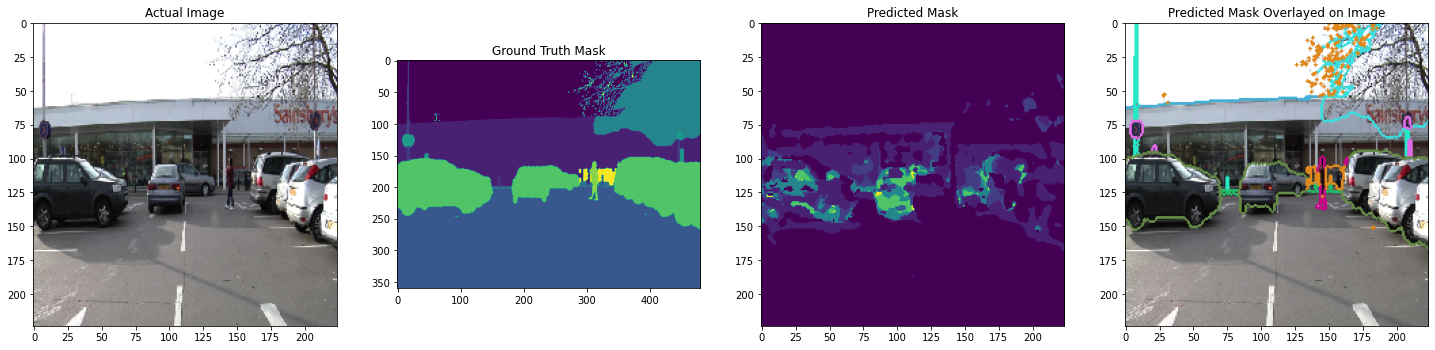

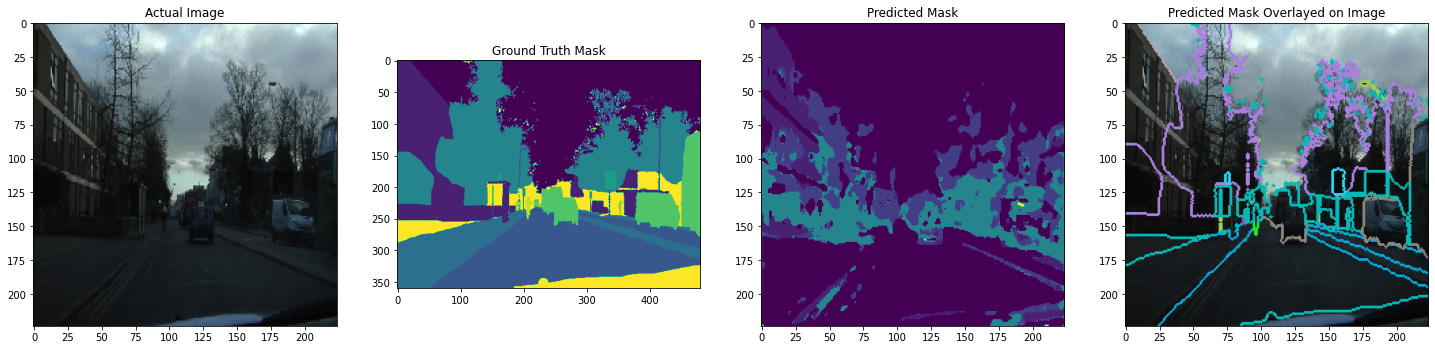

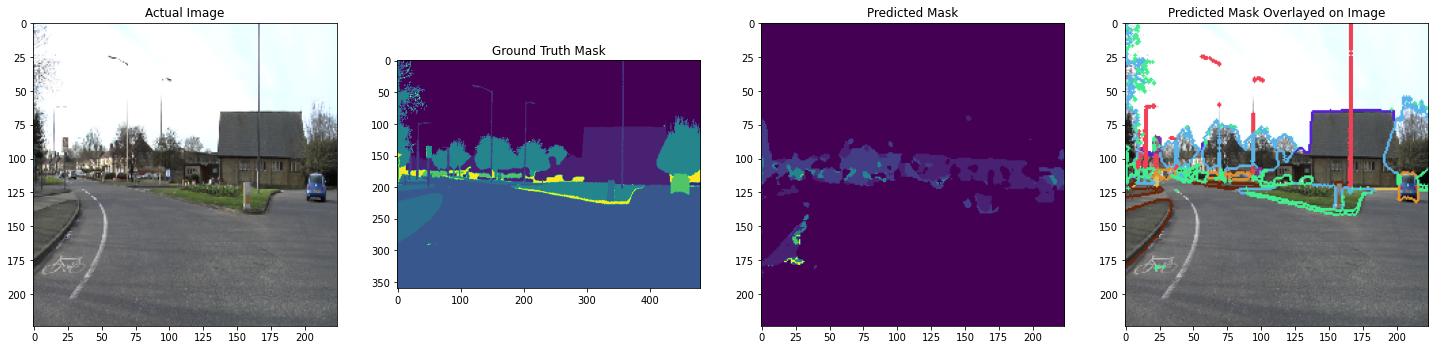

In [46]:
for number in [15,25,50,160,202]:
  img = img_to_array(load_img(train_pairs[number][0], target_size=(224,224)))
  img = np.expand_dims(img,axis=0)
  mask = model_prediction(model1, img)
  plot_examples_after_training(train_pairs, number, mask, (224, 224))